In [1]:
from keras.utils import np_utils
import numpy as np
import tensorflow as tf
import os
from PIL import Image
from PIL import ImageFilter
import image_utils as iu
import uuid
from shutil import copy2

In [25]:
data_path = 'data'
segmentation_path = os.path.join(data_path, 'segmentation')
#Mining 1 contains satellite images from Google Earth taken with screenshots.
mining_path = os.path.join(segmentation_path, 'mining')
# original images
mining_original_path = os.path.join(mining_path, 'mining-original')
mining_real_data_path = os.path.join(mining_original_path, 'real')
mining_mask_data_path = os.path.join(mining_original_path, 'mask')
# divided images
mining_divided_data_path = os.path.join(mining_path, 'mining-sites-divided')
mining_real_divided_data_path = os.path.join(mining_divided_data_path, 'real')
mining_mask_divided_data_path = os.path.join(mining_divided_data_path, 'mask')
#
mining_final_data_path = os.path.join(mining_path, 'mining-sites-final')
mining_real_final_data_path = os.path.join(mining_final_data_path, 'real')
mining_mask_final_data_path = os.path.join(mining_final_data_path, 'mask')
#
others_path = os.path.join(segmentation_path, 'others')
others_data_path = os.path.join(others_path, 'others-original')
others_divided_data_path = os.path.join(others_path, 'others-divided')
others_final_data_path = os.path.join(others_path, 'others-final')
others_real_final_data_path = os.path.join(others_final_data_path, 'real')
others_mask_final_data_path = os.path.join(others_final_data_path, 'mask')
# training data paths
training_path = os.path.join(segmentation_path, 'training')
#train
train_path = os.path.join(training_path, 'train')
train_real_path = os.path.join(train_path, 'real', 'images')
train_mask_path = os.path.join(train_path, 'mask', 'images')
#val
val_path = os.path.join(training_path, 'val')
val_real_path = os.path.join(val_path, 'real', 'images')
val_mask_path = os.path.join(val_path, 'mask', 'images')
#test
test_path = os.path.join(training_path, 'test')
test_real_path = os.path.join(test_path, 'real', 'images')
test_mask_path = os.path.join(test_path, 'mask', 'images')

In [26]:
# Splits image into specified rows and columns
def split_image(image, row_count, col_count):
    parts = []
    width, height = image.size
    left = 0
    top = 0
    right = width / col_count
    bottom = height / row_count
    for r in range(row_count):
        top = int(r * (height / row_count))
        bottom = int(top + (height / row_count))
        for c in range(col_count):
            left = int(c * (width / col_count))
            right = int(left + (width / col_count))
            part = image.crop((left, top, right, bottom))
            parts.append(part)
    return parts

In [27]:
# Augments images by rotation.
def aug_image(image):
    images_augmented = []
    image = image.resize((1024, 512))
    new_im = image
    images_augmented.append(new_im)
    images_augmented.append(new_im.rotate(90))
    images_augmented.append(new_im.rotate(180))
    images_augmented.append(new_im.rotate(270))
    new_im = image.transpose(Image.FLIP_LEFT_RIGHT)
    images_augmented.append(new_im)
    images_augmented.append(new_im.rotate(90))
    images_augmented.append(new_im.rotate(180))
    images_augmented.append(new_im.rotate(270))
    return images_augmented


In [28]:
# stores the path of an image and a mask pair
class MiningImage:
    def __init__(self, real_image_path, mask_path):
        self.real_image_path = real_image_path
        self.mask_path = mask_path

In [29]:
# real_images_path = iu.get_all_files(mining_data_path)
mask_images_path = iu.get_all_files(mining_mask_data_path)

In [30]:
# Gets the file path of real images and its mask pair.
mining_images = []
for path in mask_images_path:
    mining_image = MiningImage(os.path.join(mining_real_data_path, path), os.path.join(mining_mask_data_path, path))
    mining_images.append(mining_image)

In [32]:
# images are divided into 9 parts and saved on disk.
# This reduces the dimension of the images and also increases the training data.
iu.create_dir_if_not_exists(mining_divided_data_path)
iu.create_dir_if_not_exists(mining_real_divided_data_path)
iu.create_dir_if_not_exists(mining_mask_divided_data_path)
for mining_image in mining_images:
    row_count = 3
    col_count = 3
    part_count = col_count * row_count
    real_image = iu.read_image(mining_image.real_image_path, 'RGB')
    mask_image = iu.read_image(mining_image.mask_path, 'L')
    real_image_parts = split_image(real_image, row_count, col_count)
    mask_image_parts = split_image(mask_image, row_count, col_count)
    for x in range(part_count):
        part_filename = str(uuid.uuid4()) + '.jpg'
        real_image_part = real_image_parts[x]
        mask_image_part = mask_image_parts[x]
        #
        real_image_part.save(os.path.join(mining_real_divided_data_path, part_filename))
        mask_image_part.save(os.path.join(mining_mask_divided_data_path, part_filename))


In [33]:
mining_divided_images_path = iu.get_all_files(mining_real_divided_data_path)

In [34]:
mining_images_divided = []
for path in mining_divided_images_path:
    mining_image = MiningImage(os.path.join(mining_real_divided_data_path, path),
                               os.path.join(mining_mask_divided_data_path, path))
    mining_images_divided.append(mining_image)

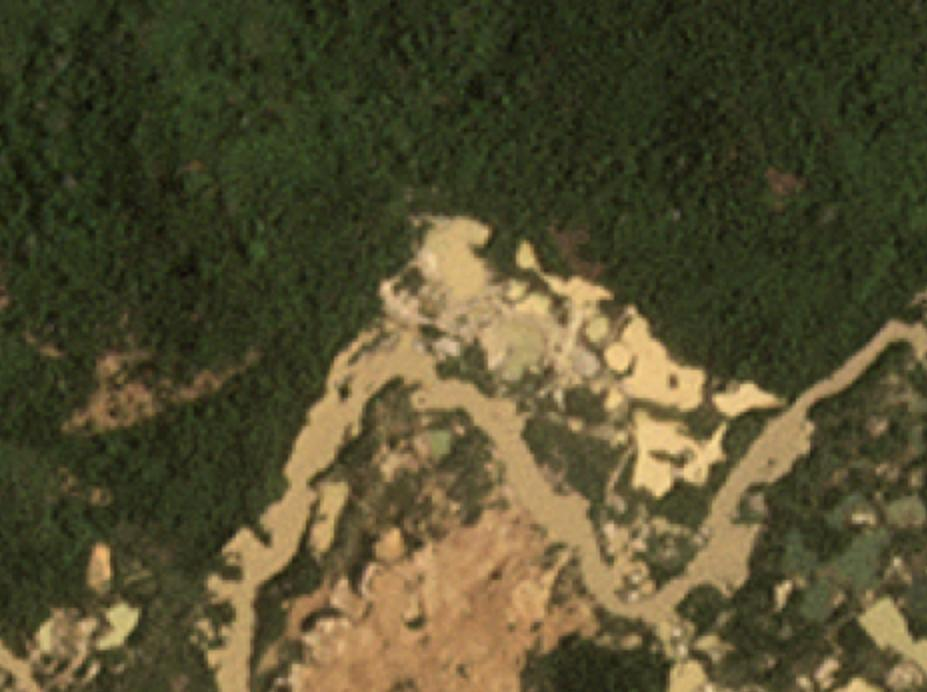

In [35]:
iu.read_image(mining_images_divided[1].real_image_path)


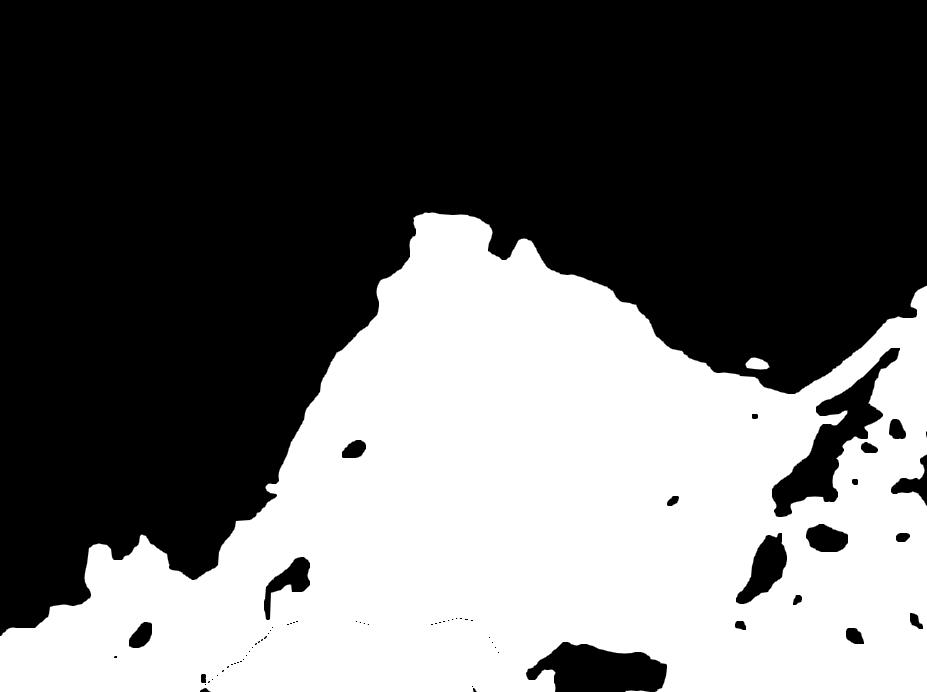

In [37]:
iu.read_image(mining_images_divided[1].mask_path)


In [38]:
# images are augmented and saved on disk.
iu.create_dir_if_not_exists(mining_final_data_path)
iu.create_dir_if_not_exists(mining_real_final_data_path)
iu.create_dir_if_not_exists(mining_mask_final_data_path)
for mining_image in mining_images_divided:
    real_image = iu.read_image(mining_image.real_image_path, 'RGB')
    mask_image = iu.read_image(mining_image.mask_path, 'L')
    real_aug_images = aug_image(real_image)
    mask_aug_images = aug_image(mask_image)
    for x in range(len(real_aug_images)):
        part_filename = str(uuid.uuid4()) + '.jpg'
        real_image_part = real_aug_images[x]
        mask_image_part = mask_aug_images[x]
        #
        real_image_part.save(os.path.join(mining_real_final_data_path, part_filename))
        mask_image_part.save(os.path.join(mining_mask_final_data_path, part_filename))


In [39]:
# The original images are also augmented and saved on disk
for mining_image in mining_images:
    real_image = iu.read_image(mining_image.real_image_path, 'RGB')
    mask_image = iu.read_image(mining_image.mask_path, 'L')
    real_aug_images = aug_image(real_image)
    mask_aug_images = aug_image(mask_image)
    # real_aug_images = [real_image]
    # mask_aug_images = [mask_image]
    for x in range(len(real_aug_images)):
        part_filename = str(uuid.uuid4()) + '.jpg'
        real_image_part = real_aug_images[x]
        mask_image_part = mask_aug_images[x]
        #
        # real_image_part = iu.set_image_contrast(real_image_part, 2)
        real_image_part.save(os.path.join(mining_real_final_data_path, part_filename))
        mask_image_part.save(os.path.join(mining_mask_final_data_path, part_filename))


Prepare Train, val and test folder

In [40]:
mining_real_final_images_path = iu.get_all_files(mining_real_final_data_path)

In [41]:
mining_images_final = []
for path in mining_real_final_images_path:
    mining_image = MiningImage(os.path.join(mining_real_final_data_path, path),
                               os.path.join(mining_mask_final_data_path, path))
    mining_images_final.append(mining_image)

In [42]:
# Splits dataset into training, validation and test sets.
def train_val_test_split(val_per ,test_per, input_data, labels = None):
    if labels is not None and len(input_data) != len(labels):
        raise Exception("input data and label length mismatch")
    data_len = len(input_data)
    val_len = int(data_len * (val_per / 100))
    test_len = int(data_len * (test_per / 100))
    x_val = input_data[0: val_len]
    x_test = input_data[val_len: val_len + test_len]
    x_train = input_data[val_len + test_len: data_len]
    if labels is not None:
        y_val = labels[0: val_len]
        y_test = labels[val_len: val_len + test_len]
        y_train = labels[val_len + test_len: data_len]
        return (x_train, y_train), (x_val, y_val), (x_test, y_test)
    else:
        return x_train, x_val, x_test

In [44]:
train_images, val_images, test_images = train_val_test_split(15, 10, mining_images_final)
print('Train length:', len(train_images))
print('Val length:', len(val_images))
print('Test length', len(test_images))

Train length: 3120
Val length: 624
Test length 416


In [45]:
#create directories for all training data.
training_path = os.path.join(segmentation_path, 'training')
iu.create_dir_if_not_exists(training_path)
#train
train_path = os.path.join(training_path, 'train')
iu.create_dir_if_not_exists(train_path)
train_real_path = os.path.join(train_path, 'real', 'images')
iu.create_dir_if_not_exists(train_real_path)
train_mask_path = os.path.join(train_path, 'mask', 'images')
iu.create_dir_if_not_exists(train_mask_path)
#val
val_path = os.path.join(training_path, 'val')
iu.create_dir_if_not_exists(val_path)
val_real_path = os.path.join(val_path, 'real', 'images')
iu.create_dir_if_not_exists(val_real_path)
val_mask_path = os.path.join(val_path, 'mask', 'images')
iu.create_dir_if_not_exists(val_mask_path)
#test
test_path = os.path.join(training_path, 'test')
iu.create_dir_if_not_exists(test_path)
test_real_path = os.path.join(test_path, 'real', 'images')
iu.create_dir_if_not_exists(test_real_path)
test_mask_path = os.path.join(test_path, 'mask', 'images')
iu.create_dir_if_not_exists(test_mask_path)

In [46]:
# copy training images to training folder
for image in train_images:
    copy2(image.real_image_path, os.path.join(train_real_path, os.path.basename(image.real_image_path)))
    copy2(image.mask_path, os.path.join(train_mask_path, os.path.basename(image.mask_path)))

In [49]:
# copy validation images to val folder
for image in val_images:
    copy2(image.real_image_path, os.path.join(val_real_path, os.path.basename(image.real_image_path)))
    copy2(image.mask_path, os.path.join(val_mask_path, os.path.basename(image.mask_path)))

In [50]:
# copy testing images to test folder
for image in test_images:
    copy2(image.real_image_path, os.path.join(test_real_path, os.path.basename(image.real_image_path)))
    copy2(image.mask_path, os.path.join(test_mask_path, os.path.basename(image.mask_path)))